## Precipitation extremes and org - all models + obs

In [96]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)


from os.path import expanduser
home = expanduser("~")

In [97]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

In [98]:
def plot_scatterColor(x,y, prE, org, x_leg, label, colors, title):
    fig = plt.figure(figsize=(12.5,8))
    plt.scatter(x,y,facecolors='none', edgecolor='k')


    res= stats.pearsonr(x,y)
    j=0
    for i in x_leg:
        plt.scatter(x[i],y[i],c=colors[j], label=label[j])
        j+=1

    plt.title(title)
    plt.xlabel(org_option  + ' [' + org.units + ']')
    plt.ylabel(prE_option + ' ['+ prE.units +']')
    plt.legend()

In [99]:
def plot_scatter(ax, x,y):
    plt.scatter(x,y,facecolors='none', edgecolor='k')
    res= stats.pearsonr(x,y)
    if res[1]<=0.05:
        ax.annotate('R$^2$: '+ str(round(res[0]**2,3)), xy=(0.2, 0.1), xycoords='axes fraction', xytext=(0.05, 0.875), textcoords='axes fraction')


In [100]:
def plot_bins(ax, x,y, bin_type):    
    bin_width = (x.max() - x.min())/100
    bin_end = x.max()
    bins = np.arange(0, bin_end+bin_width, bin_width)

    y_bins = []
    for i in np.arange(0,len(bins)-1):
        y_bins = np.append(y_bins, y.where((x>=bins[i]) & (x<=bins[i+1])).mean())
    plt.plot(y_bins)

In [101]:
def plot_timeseriesHighlight(ax, x, y, threshold):
    ax.plot(y, label= prE_option)
    ax.scatter(x,y[x],label=org_option + ' ' + str(threshold) + 'th percentile', color='r')
    ax.axhline(y=y.mean(), color='k')

In [102]:
models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    'GISS-E2-H',    # 3
    'bcc-csm1-1',   # 4
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8
    'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    'inmcm4',       # 13
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    'HadGEM2-CC',   # 17
    'MRI-CGCM3',    # 18
    'CESM1-BGC'     # 19
    # ''
    ]

experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]

observations = {
    'GPCP'
    # ''
    }

org_options = [
    'rome',
    # 'rome_n',
    # 'o_number'
    ]
org_option = org_options[0]

prE_options = [
    'pr99',
    # 'rx1day',
    # 'rx5day'
    ]
prE_option = prE_options[0]




## intra-model analysis

### annual

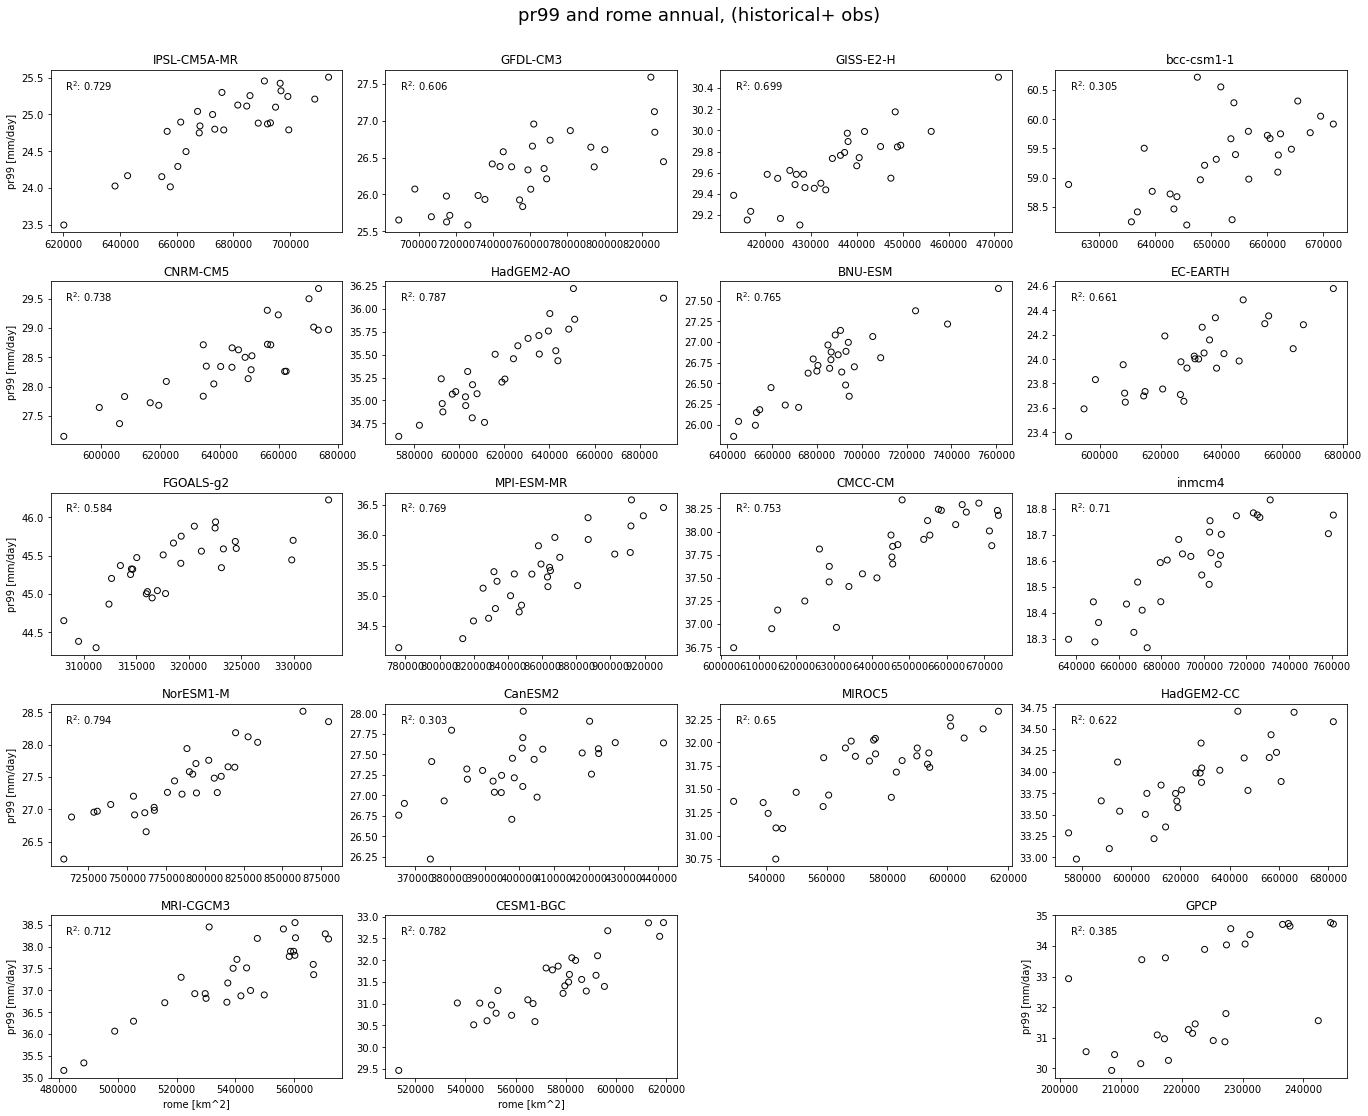

In [103]:
fig= plt.figure(figsize=(22.5,17.5))
fig.suptitle(prE_option + ' and ' + org_option  + ' annual, (' + experiment + '+ obs)', fontsize=18, y=0.95)

for i, model in enumerate(models):

    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_' + experiment + '.nc')[org_option].resample(time='Y').mean(dim='time',keep_attrs=True)

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_' + experiment + '.nc')[org_option].resample(time='Y').mean(dim='time',keep_attrs=True)

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc')[prE_option].resample(time='Y').mean(dim='time',keep_attrs=True)

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        lat = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_' + experiment + '.nc')[prE_option].lat
        aWeights = np.cos(np.deg2rad(lat))
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_rxday_' + experiment + '.nc')[prE_option].weighted(aWeights).mean(dim=('lat','lon'),keep_attrs=True)
        prE.attrs['units']= 'mm/day'


    ax= fig.add_subplot(5,4,i+1)
    x = org
    y = prE
    
    plot_scatter(ax, x,y)
    ax.set_title(model)

    #ax.spines.right.set_visible(False)
    #ax.spines.top.set_visible(False)
    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ax.set_ylabel(prE_option + ' [mm/day]')

    if i>=16:
        ax.set_xlabel(org_option + ' [' + x.units + ']')



for i, obs in enumerate(observations):

    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rome.nc')[org_option].resample(time='Y').mean(dim='time',keep_attrs=True)

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_numberIndex.nc')[org_option].resample(time='Y').mean(dim='time',keep_attrs=True)

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc')[prE_option].resample(time='Y').mean(dim='time',keep_attrs=True)

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        lat = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rxday.nc')[prE_option].lat
        aWeights = np.cos(np.deg2rad(lat))
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rxday.nc')[prE_option].weighted(aWeights).mean(dim=('lat','lon'),keep_attrs=True)
        prE.attrs['units']= 'mm/day'


    ax= fig.add_subplot(5,4,20-i)
    x = org
    y = prE
    
    plot_scatter(ax, x,y)
    ax.set_title(obs)

    #ax.spines.right.set_visible(False)
    #ax.spines.top.set_visible(False)
    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ax.set_ylabel(prE_option + ' [mm/day]')

    if i>=16:
        ax.set_xlabel(org_option + ' [' + x.units + ']')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)
#sns.despine(top=True, right=True, left=False, bottom=False)


### daily

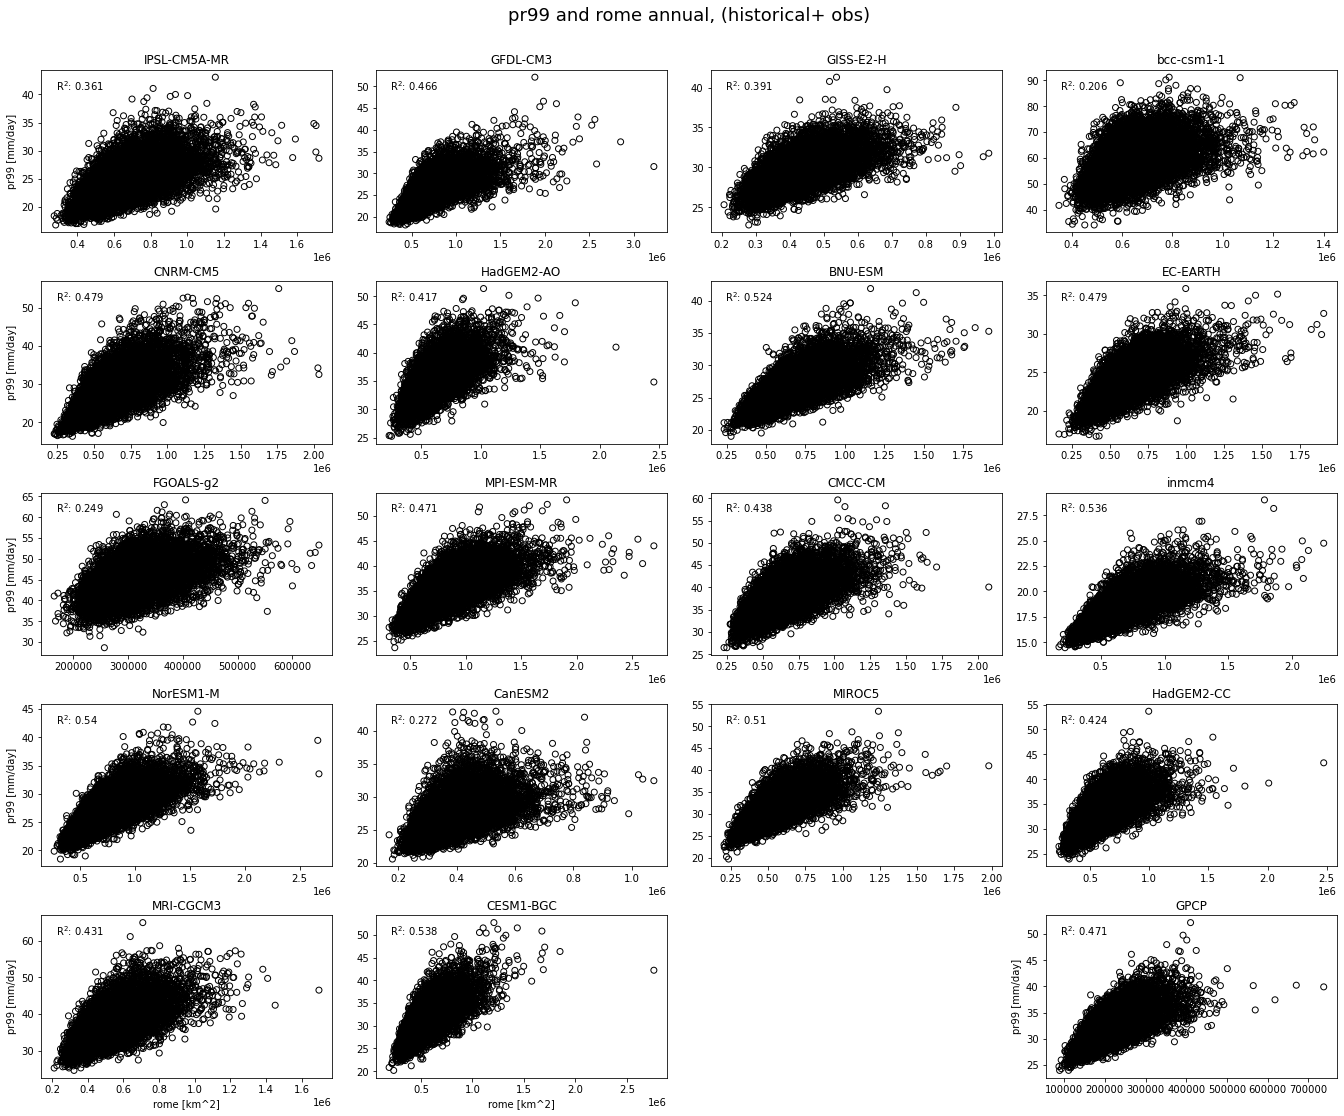

In [104]:
fig= plt.figure(figsize=(22.5,17.5))
fig.suptitle(prE_option + ' and ' + org_option  + ' annual, (' + experiment + '+ obs)', fontsize=18, y=0.95)

for i, model in enumerate(models):

    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_' + experiment + '.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_' + experiment + '.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue


    ax= fig.add_subplot(5,4,i+1)
    x = org
    y = prE
    
    plot_scatter(ax, x,y)
    ax.set_title(model)

    #ax.spines.right.set_visible(False)
    #ax.spines.top.set_visible(False)
    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ax.set_ylabel(prE_option + ' [mm/day]')

    if i>=16:
        ax.set_xlabel(org_option + ' [' + x.units + ']')



for i, obs in enumerate(observations):

    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rome.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_numberIndex.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue


    ax= fig.add_subplot(5,4,20-i)
    x = org
    y = prE
    
    plot_scatter(ax, x,y)
    ax.set_title(obs)

    #ax.spines.right.set_visible(False)
    #ax.spines.top.set_visible(False)
    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ax.set_ylabel(prE_option + ' [mm/day]')

    if i>=16:
        ax.set_xlabel(org_option + ' [' + x.units + ']')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)
#sns.despine(top=True, right=True, left=False, bottom=False)


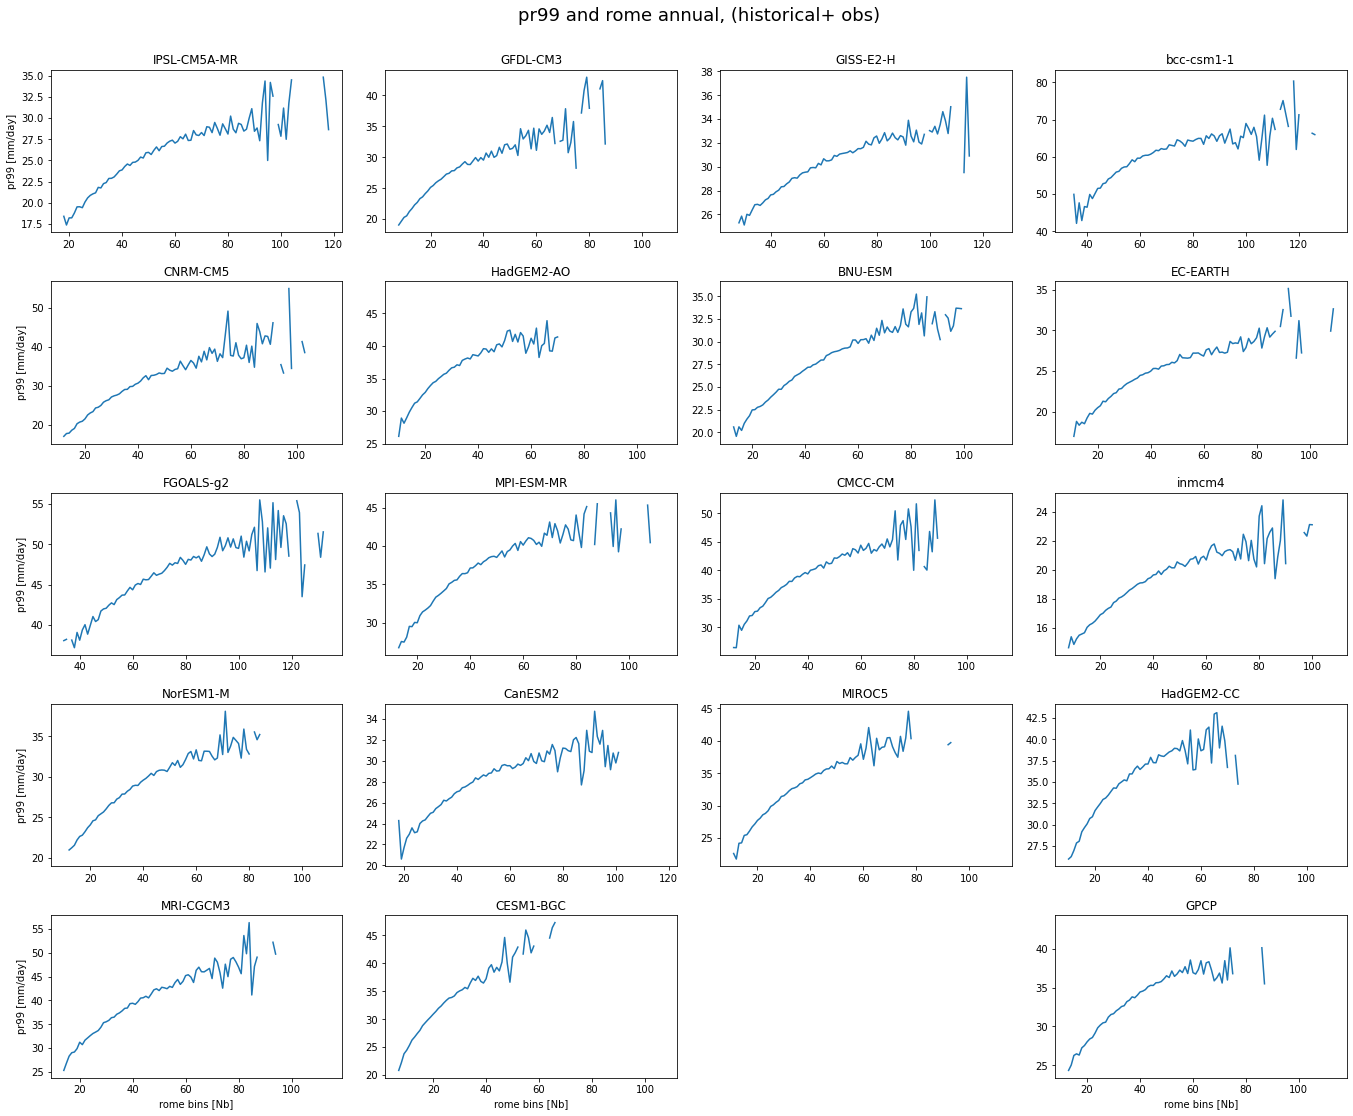

In [105]:
bin_type = 'daily'
fig= plt.figure(figsize=(22.5,17.5))
fig.suptitle(prE_option + ' and ' + org_option  + ' annual, (' + experiment + '+ obs)', fontsize=18, y=0.95)

for i, model in enumerate(models):
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_' + experiment + '.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_' + experiment + '.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue


    ax= fig.add_subplot(5,4,i+1)
    x = org
    y = prE
    
    plot_bins(ax, x,y, bin_type)
    ax.set_title(model)

    #ax.spines.right.set_visible(False)
    #ax.spines.top.set_visible(False)
    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ax.set_ylabel(prE_option + ' [mm/day]')

    if i>=16:
        ax.set_xlabel(org_option + ' bins [Nb]') #' [' + x.units + ']')



for i, obs in enumerate(observations):
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rome.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_numberIndex.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue


    ax= fig.add_subplot(5,4,20-i)
    x = org
    y = prE
    
    plot_bins(ax, x,y, bin_type)
    ax.set_title(obs)
    ax.set_xlabel(org_option + ' bins [Nb]') #+ ' [' + x.units + ']')


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)
#sns.despine(top=True, right=True, left=False, bottom=False)



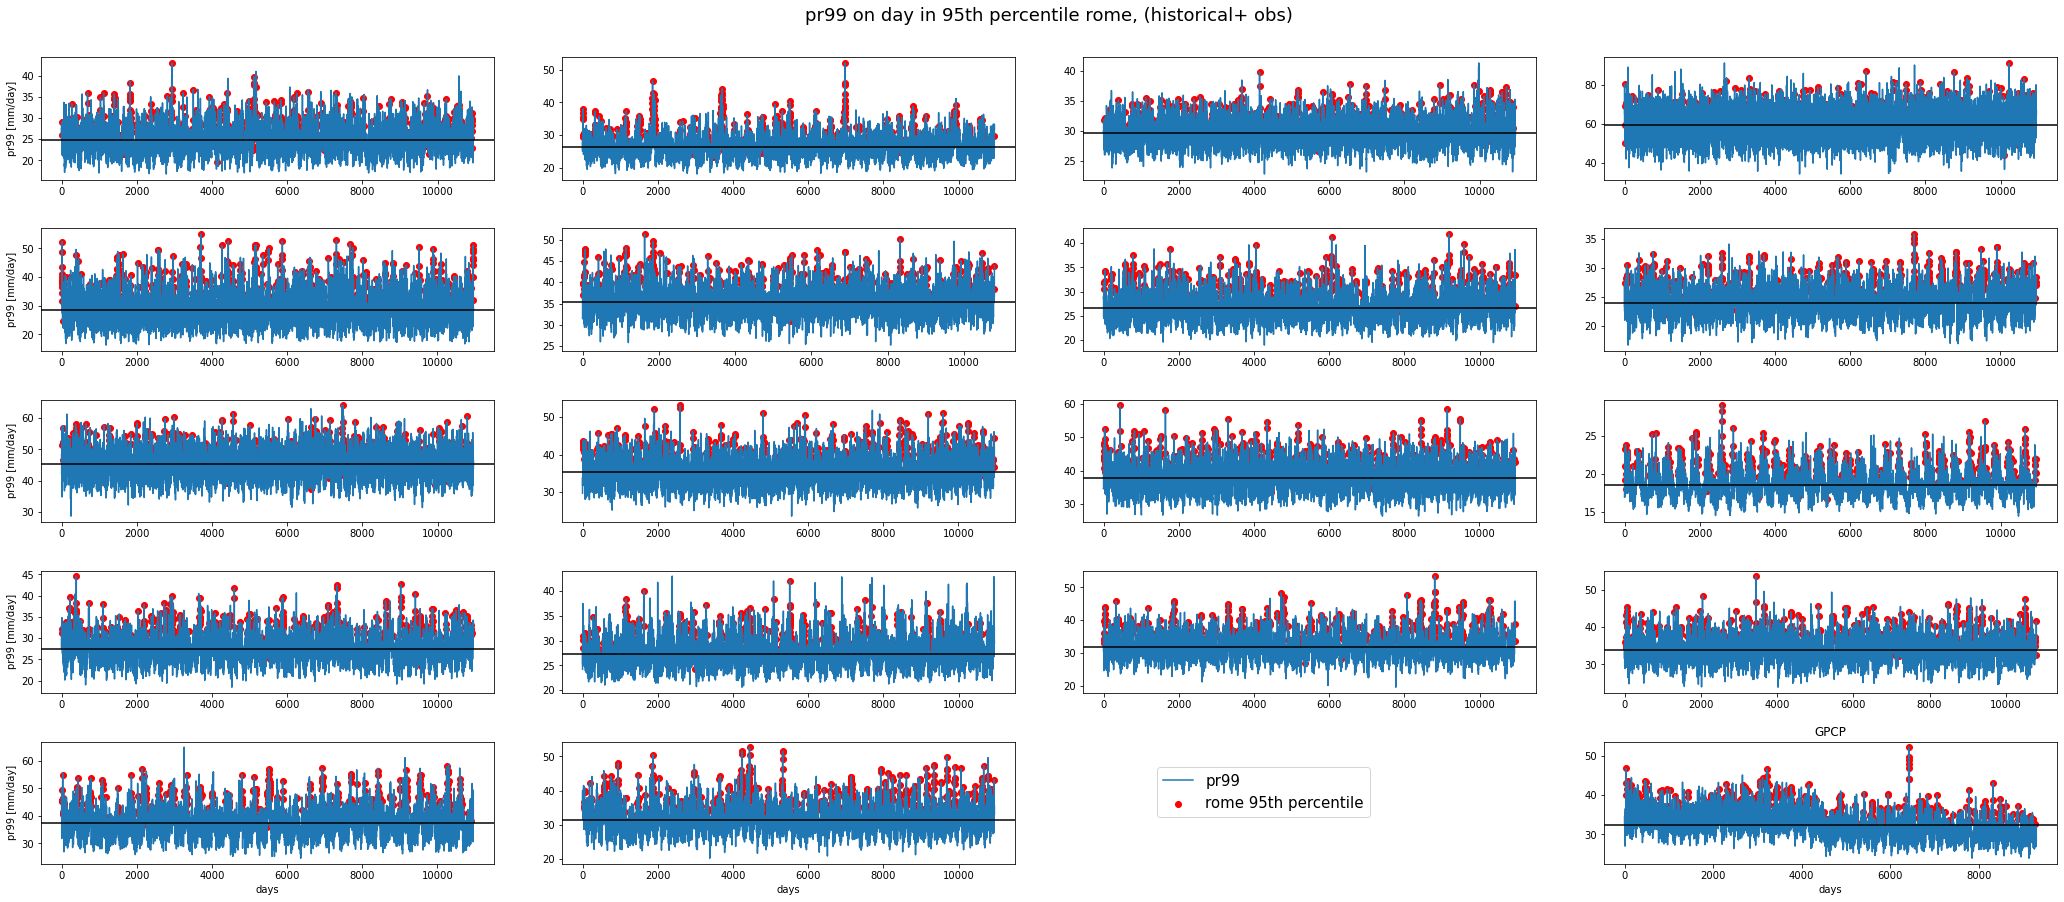

In [106]:
threshold = 95
title_sup = prE_option + ' on day in ' + str(threshold) + 'th percentile ' + org_option + ', (' + experiment + '+ obs)'

f, axes = plt.subplots(nrows=5, ncols=4, figsize = (35,14))
f.suptitle(title_sup, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_' + experiment + '.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_' + experiment + '.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue

    org_threshold = np.percentile(org,threshold)
    x = np.argwhere(org.data>=org_threshold)
    y = prE.data

    plot_timeseriesHighlight(ax, x, y, threshold)
    plt.title(model)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('days')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(prE_option + ' [mm/day]')



for i, obs in enumerate(observations):
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rome.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_numberIndex.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue

    org_threshold = np.percentile(org,threshold)
    x = np.argwhere(org.data>=org_threshold)
    y = prE.data

    ax = axes[-1,-1]

    plot_timeseriesHighlight(ax, x, y, threshold)
    plt.title(model)
    plt.title(obs)
    plt.xlabel('days')




plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, -2].remove()
plt.legend(bbox_to_anchor=(-0.5, 0.85), fontsize= 15)

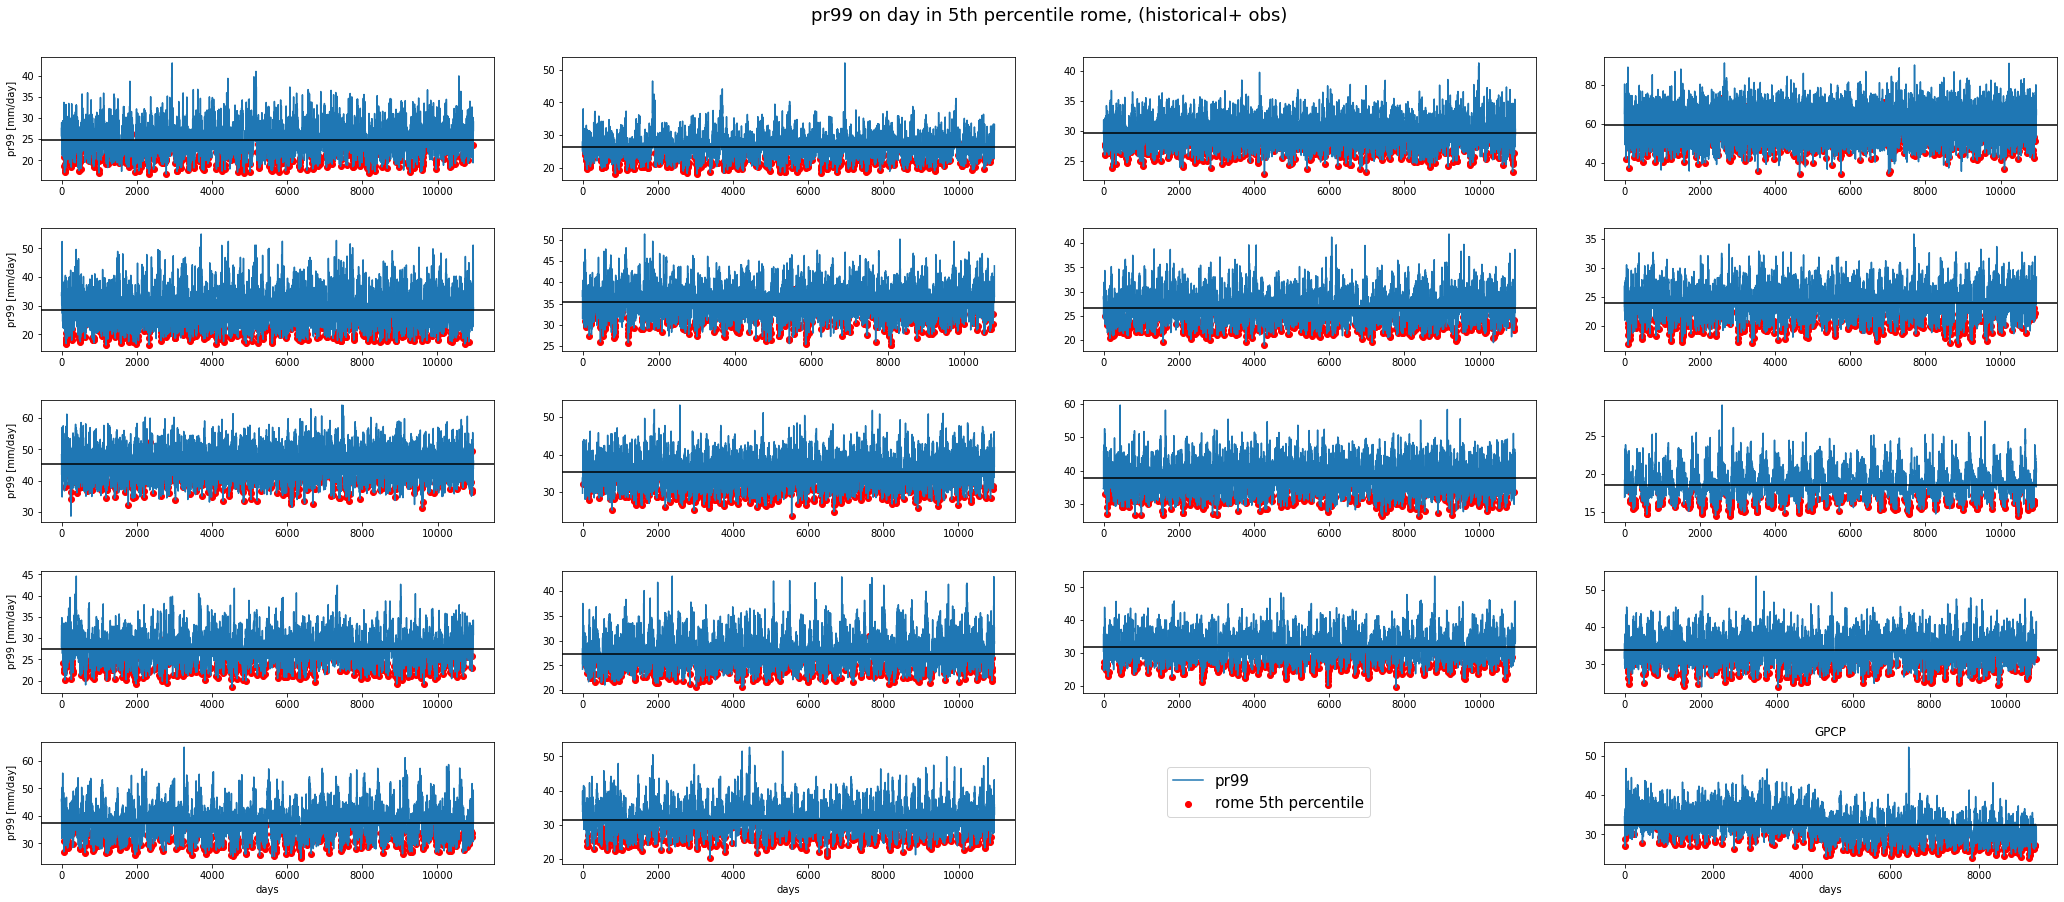

In [107]:
threshold = 5
title_sup = prE_option + ' on day in ' + str(threshold) + 'th percentile ' + org_option + ', (' + experiment + '+ obs)'

f, axes = plt.subplots(nrows=5, ncols=4, figsize = (35,14))
f.suptitle(title_sup, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_' + experiment + '.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_' + experiment + '.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue

    org_threshold = np.percentile(org,threshold)
    x = np.argwhere(org.data<=org_threshold)
    y = prE.data

    plot_timeseriesHighlight(ax, x, y, threshold)
    plt.title(model)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('days')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(prE_option + ' [mm/day]')



for i, obs in enumerate(observations):
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rome.nc')[org_option]

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_numberIndex.nc')[org_option]

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc')[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        continue

    org_threshold = np.percentile(org,threshold)
    x = np.argwhere(org.data<=org_threshold)
    y = prE.data

    ax = axes[-1,-1]

    plot_timeseriesHighlight(ax, x, y, threshold)
    plt.title(model)
    plt.title(obs)
    plt.xlabel('days')




plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, -2].remove()
plt.legend(bbox_to_anchor=(-0.5, 0.85), fontsize= 15)

## inter-model analysis

### climatology

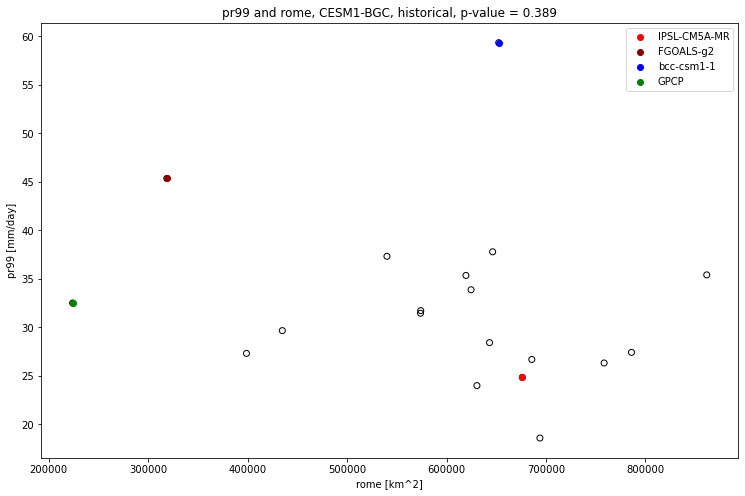

In [108]:
x= []
y= []
for model in models:
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_' + experiment + '.nc')[org_option].mean(dim='time',keep_attrs=True)

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_' + experiment + '.nc')[org_option].mean(dim='time',keep_attrs=True)

    if prE_option == 'pr99': 
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc')[prE_option].mean(dim='time',keep_attrs=True)

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        lat = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_rxday' + experiment + '.nc')[prE_option].lat
        aWeights = np.cos(np.deg2rad(lat))
        prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_rxday_' + experiment + '.nc')[prE_option].weighted(aWeights).mean(dim=('time', 'lat','lon'),keep_attrs=True)
        prE.attrs['units']= 'mm/day'

    x = np.append(x, org)
    y = np.append(y, prE)

res= stats.pearsonr(x,y)

for obs in observations:
    if org_option == 'rome' or org_option == 'rome_n':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rome.nc')[org_option].mean(dim='time',keep_attrs=True)

    if org_option == 'o_number':
        org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_numberIndex.nc')[org_option].mean(dim='time',keep_attrs=True)
    
    if prE_option == 'pr99':
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc')[prE_option].mean(dim='time',keep_attrs=True)

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        lat = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rxday.nc')[prE_option].lat
        aWeights = np.cos(np.deg2rad(lat))
        prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rxday.nc')[prE_option].weighted(aWeights).mean(dim=('time', 'lat','lon'),keep_attrs=True)
        prE.attrs['units']= 'mm/day'

    x = np.append(x, org)
    y = np.append(y, prE)

title = prE_option  + ' and ' + org_option + ', ' + model + ', ' + experiment + ', p-value = '+ str(round(res[1],3))


if observations:
    x_leg = [models.index('IPSL-CM5A-MR'),models.index('FGOALS-g2'), models.index('bcc-csm1-1'), -1]
    label = ['IPSL-CM5A-MR','FGOALS-g2','bcc-csm1-1', 'GPCP']
    colors = ['r','darkred','b', 'g']
else:
    x_leg = [models.index('IPSL-CM5A-MR'),models.index('FGOALS-g2'), models.index('bcc-csm1-1')]
    label = ['IPSL-CM5A-MR','FGOALS-g2','bcc-csm1-1']
    colors = ['r','darkred','b']

plot_scatterColor(x,y, prE, org, x_leg, label, colors, title)

### change with warming

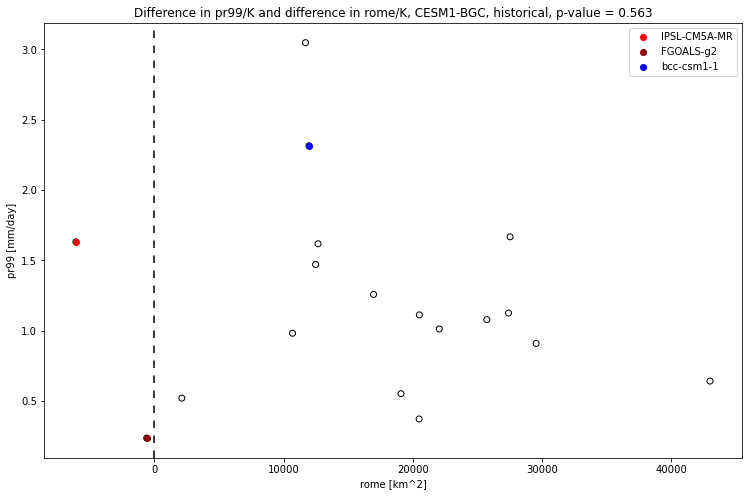

In [109]:
x= []
y= []
for model in models:

    tas2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_tas_sMean_rcp85.nc')['tas_sMean'].mean(dim='time')
    tas1 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_tas_sMean_historical.nc')['tas_sMean'].mean(dim='time')
    tas_diff = tas2 - tas1

    if org_option == 'rome' or org_option == 'rome_n':
        org2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_rcp85.nc')[org_option].mean(dim='time')
        org1 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_historical.nc')[org_option].mean(dim='time')

    if org_option == 'o_number':
        org2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_rcp85.nc')[org_option].mean(dim='time')
        org1 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_historical.nc')[org_option].mean(dim='time')

    if prE_option == 'pr99': 
        prE2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_rcp85.nc')[prE_option].mean(dim='time')
        prE1 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_historical.nc')[prE_option].mean(dim='time')

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        lat = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_rxday_rcp85.nc')[prE_option].lat
        aWeights = np.cos(np.deg2rad(lat))
        prE2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_rxday_rcp85.nc')[prE_option].weighted(aWeights).mean(dim=('time','lat','lon'),keep_attrs=True)
        prE2.attrs['units']= 'mm/day'
        prE1 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_rxday_historical.nc')[prE_option].weighted(aWeights).mean(dim=('time','lat','lon'),keep_attrs=True)
        prE1.attrs['units']= 'mm/day'


    x = np.append(x, (org2-org1)/tas_diff)
    y = np.append(y, (prE2-prE1)/tas_diff)

res= stats.pearsonr(x,y)


title = 'Difference in ' + prE_option  + '/K and difference in ' + org_option + '/K, ' + model + ', ' + experiment + ', p-value = '+ str(round(res[1],3))
x_leg = [models.index('IPSL-CM5A-MR'),models.index('FGOALS-g2'), models.index('bcc-csm1-1')]
label = ['IPSL-CM5A-MR','FGOALS-g2','bcc-csm1-1']
colors = ['r','darkred','b']

plot_scatterColor(x,y, prE, org, x_leg, label, colors, title)
plt.axvline(0, color='k',linestyle= (0, (5, 5)))



## other

### monthly

In [110]:
# fig= plt.figure(figsize=(22.5,17.5))
# fig.suptitle(prE_option + ' and ' + org_option  + ' annual, ' + experiment, fontsize=18, y=0.95)

# for i, model in enumerate(models):

#     if org_option == 'rome' or org_option == 'rome_n':
#         org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' +  model + '_rome_' + experiment + '.nc')[org_option].resample(time='M').mean(dim='time',keep_attrs=True)

#     if org_option == 'o_number':
#         org = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_numberIndex_' + experiment + '.nc')[org_option].resample(time='M').mean(dim='time',keep_attrs=True)

#     if prE_option == 'pr99': 
#         prE = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc')[prE_option].resample(time='M').mean(dim='time',keep_attrs=True)

#     if prE_option == 'rx1day' or prE_option == 'rx5day':
#         continue

#     ax= fig.add_subplot(5,4,i+1)
#     x = org
#     y = prE
    
#     plot_scatter(ax, x,y)
#     ax.set_title(model)

#     #ax.spines.right.set_visible(False)
#     #ax.spines.top.set_visible(False)
#     if i== 0 or i==4 or i==8 or i==12 or i==16:
#         ax.set_ylabel(prE_option + ' [mm/day]')

#     if i>=16:
#         ax.set_xlabel(org_option + ' [' + x.units + ']')



# for i, obs in enumerate(observations):

#     if org_option == 'rome' or org_option == 'rome_n':
#         org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_rome.nc')[org_option].resample(time='Y').mean(dim='time',keep_attrs=True)

#     if org_option == 'o_number':
#         org = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_numberIndex.nc')[org_option].resample(time='Y').mean(dim='time',keep_attrs=True)

#     if prE_option == 'pr99': 
#         prE = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc')[prE_option].resample(time='Y').mean(dim='time',keep_attrs=True)

#     if prE_option == 'rx1day' or prE_option == 'rx5day':
#         continue

#     ax= fig.add_subplot(5,4,20-i)
#     x = org
#     y = prE
    
#     plot_scatter(ax, x,y)
#     ax.set_title(model)

#     #ax.spines.right.set_visible(False)
#     #ax.spines.top.set_visible(False)
#     if i== 0 or i==4 or i==8 or i==12 or i==16:
#         ax.set_ylabel(prE_option + ' [mm/day]')

#     if i>=16:
#         ax.set_xlabel(org_option + ' [' + x.units + ']')


# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)
# #sns.despine(top=True, right=True, left=False, bottom=False)
